In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from IPython import display
from jiwer import wer
import os

In [4]:
project_dir = os.path.abspath("datasets")
data_url = 'https://data.keithito.com/data/speech/LJSpeech-1.1.tar.bz2'
data_path = keras.utils.get_file(
    fname="LJSpeech-1.1",
    origin=data_url,
    untar=True,
    cache_dir=project_dir 
)

print("Dataset saved at:", data_path)

Dataset saved at: c:\Users\HP\Desktop\VoiceVibe\datasets\datasets\LJSpeech-1.1


In [8]:
wavs_path = ".\datasets\datasets\LJSpeech-1_extracted\LJSpeech-1.1\wavs"
metadata_path = 'datasets\datasets\LJSpeech-1_extracted\LJSpeech-1.1\metadata.csv'

print("Wavs path:", wavs_path)
print("Metadata path:", metadata_path)

Wavs path: .\datasets\datasets\LJSpeech-1_extracted\LJSpeech-1.1\wavs
Metadata path: datasets\datasets\LJSpeech-1_extracted\LJSpeech-1.1\metadata.csv


In [2]:
metadata_df = pd.read_csv('datasets\datasets\LJSpeech-1_extracted\LJSpeech-1.1\metadata.csv', sep='|', header=None, quoting=3)

In [7]:
metadata_df.head(10)

,0,1,2
0,LJ001-0001,"Printing, in the only sense with which we are ...","Printing, in the only sense with which we are ..."
1,LJ001-0002,in being comparatively modern.,in being comparatively modern.
2,LJ001-0003,For although the Chinese took impressions from...,For although the Chinese took impressions from...
3,LJ001-0004,"produced the block books, which were the immed...","produced the block books, which were the immed..."
4,LJ001-0005,the invention of movable metal letters in the ...,the invention of movable metal letters in the ...
5,LJ001-0006,"And it is worth mention in passing that, as an...","And it is worth mention in passing that, as an..."
6,LJ001-0007,"the earliest book printed with movable types, ...","the earliest book printed with movable types, ..."
7,LJ001-0008,has never been surpassed.,has never been surpassed.
8,LJ001-0009,"Printing, then, for our purpose, may be consid...","Printing, then, for our purpose, may be consid..."
9,LJ001-0010,"Now, as all books not primarily intended as pi...","Now, as all books not primarily intended as pi..."


In [3]:
metadata_df.columns = ['file_name', 'transcription', 'normalized_transcription']
metadata_df = metadata_df[['file_name', 'transcription']]
metadata_df = metadata_df.sample(frac=1).reset_index(drop=True)
metadata_df.head(10)

,file_name,transcription
0,LJ014-0023,and many of the same sort were found in the po...
1,LJ025-0165,"Neither protein, nor fat, nor starch, nor suga..."
2,LJ014-0326,Maltby and Co. would issue warrants on them de...
3,LJ019-0211,It was urged that the area selected for purcha...
4,LJ041-0057,"His study of Communist literature,"
5,LJ002-0051,A high wall fifteen feet in height divided the...
6,LJ021-0012,"with respect to industry and business, but nea..."
7,LJ021-0169,"Those, fortunately few in number, who are frig..."
8,LJ043-0077,While that counselor found that he was qualifi...
9,LJ012-0079,A large amount of specie was nearly always ret...


In [4]:
split = int(0.9 * len(metadata_df))
train_df = metadata_df[:split]
test_df = metadata_df[split:]

print("Train set size:", len(train_df))
print("Test set size:", len(test_df))

Train set size: 11790
Test set size: 1310


In [5]:
characters = [x for x in "abcdefghijklmnopqrstuvwxyz'?! "]
char_to_num = keras.layers.StringLookup(vocabulary=characters, oov_token='')
num_to_char = keras.layers.StringLookup(vocabulary=char_to_num.get_vocabulary(), oov_token='', invert=True)

print(
        f"The vocabulary is: {char_to_num.get_vocabulary()}\n"
        f"(size = {len(char_to_num.get_vocabulary())})")

The vocabulary is: ['', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', "'", '?', '!', ' ']
(size = 31)


In [6]:
frame_length = 256
frame_step = 160
fft_length = 384

def encode_single_sample(wav_file, label):
    file = tf.io.read_file(wavs_path + '/' + wav_file + '.wav')
    audio, _ = tf.audio.decode_wav(file)
    audio = tf.squeeze(audio, axis=-1)
    audio = tf.cast(audio, tf.float32)
    
    spectrogram = tf.signal.stft(audio, frame_length=frame_length, frame_step=frame_step, fft_length=fft_length)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.pow(spectrogram, 0.5)
    
    means = tf.math.reduce_mean(spectrogram, 1, keepdims=True)
    stddevs = tf.math.reduce_std(spectrogram, 1, keepdims=True)
    spectrogram = (spectrogram - means) / (stddevs + 1e-10)
    
    label = tf.strings.lower(label)
    label = tf.strings.unicode_split(label, input_encoding='UTF-8')
    label = char_to_num(label)
    
    return spectrogram, label

In [9]:
batch_size = 32
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['file_name'].values, train_df['transcription'].values))
train_dataset = (
                train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .padded_batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                )

vali_dataset = tf.data.Dataset.from_tensor_slices((test_df['file_name'].values, test_df['transcription'].values))
vali_dataset = (
                vali_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .padded_batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                )


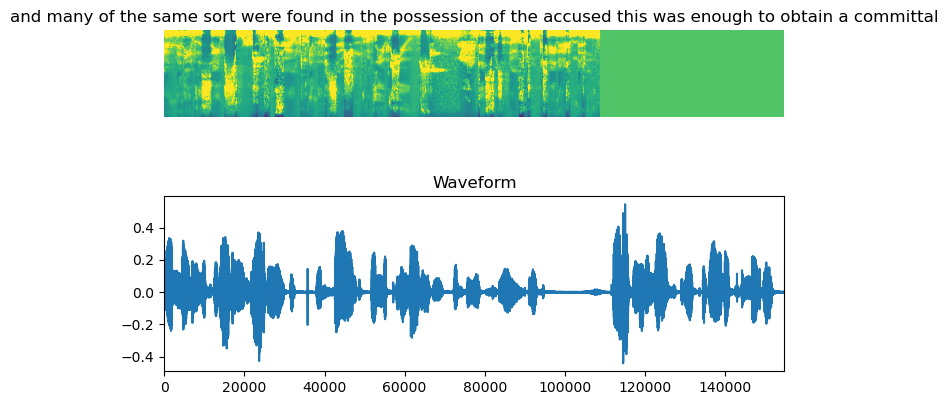

In [10]:
fig = plt.figure(figsize=(8, 5))
for batch in train_dataset.take(1):
    spectrograms = batch[0][0].numpy()
    spectrograms = np.array([x for x in np.transpose(spectrograms)])
    label = batch[1][0].numpy()
    
    label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
    ax = plt.subplot(211)
    ax.imshow(spectrograms, vmax=1)
    ax.set_title(label)
    ax.axis('off')
    
    ffile = tf.io.read_file(wavs_path + '/' + train_df['file_name'].values[0] + '.wav')
    audio, _ = tf.audio.decode_wav(ffile)
    audio = audio.numpy()
    ax = plt.subplot(212)
    plt.plot(audio)
    ax.set_title('Waveform')
    ax.set_xlim([0, len(audio)])
    display.display(display.Audio(np.transpose(audio), rate=16000))
plt.show()

In [11]:
def CTCLoss(y_true, y_pred):
    # Compute the training-time loss value
    batch_len = tf.cast(tf.shape(y_true)[0], dtype='int64')
    input_length = tf.cast(tf.shape(y_pred)[1], dtype='int64')
    label_length = tf.cast(tf.shape(y_true)[1], dtype='int64')
    
    input_length = input_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    label_length = label_length * tf.ones(shape=(batch_len, 1), dtype='int64')
    
    loss = keras.backend.ctc_batch_cost(y_true, y_pred, input_length, label_length)
    return loss

In [12]:
def build_model(input_dim, output_dim,rnn_layers=5 , rnn_units=128):
    input_spec = layers.Input((None, input_dim), name='input')
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim")(input_spec)
    x = layers.Conv2D(filters=32, kernel_size=(11, 41), strides=(2, 2), padding='same',use_bias=False, name='conv_1')(x)
    x = layers.BatchNormalization(name='conv_1_bn')(x)
    x = layers.ReLU(name='conv_1_relu')(x)
    
    x = layers.Conv2D(filters=32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False, name='conv_2')(x)
    x = layers.BatchNormalization(name='conv_2_bn')(x)
    x = layers.ReLU(name='conv_2_relu')(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation="tanh", recurrent_activation='sigmoid', use_bias=True, return_sequences=True, reset_after=True, name=f'GRU_{i}')
        x = layers.Bidirectional(recurrent, name=f'bidirectional_{i}', merge_mode="concat")(x)
        
        if i < rnn_layers:
            x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(units=rnn_units * 2, name='dense_1')(x)
    x = layers.ReLU(name='dense_1_relu')(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(units=output_dim + 1, activation='softmax')(x)
    
    model = keras.models.Model(inputs=input_spec, outputs=output, name='speech_recognition_model')
    
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    
    return model    

In [13]:
model = build_model(input_dim=fft_length // 2 + 1, output_dim=len(char_to_num.get_vocabulary()),rnn_units=512)
model.summary(line_length=100)

Model: "speech_recognition_model"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input (InputLayer)                          [(None, None, 193)]                     0              
                                                                                                    
 expand_dim (Reshape)                        (None, None, 193, 1)                    0              
                                                                                                    
 conv_1 (Conv2D)                             (None, None, 97, 32)                    14432          
                                                                                                    
 conv_1_bn (BatchNormalization)              (None, None, 97, 32)                    128            
                                                         

In [14]:
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode('utf-8')
        output_text.append(res)
    return output_text

class CallbackEval(keras.callbacks.Callback):
    def __init__(self, dataset):
        super().__init__()
        self.dataset = dataset
    
    def on_epoch_end(self, epoch, logs=None):
        predictions = []
        targets = []
        for batch in self.dataset:
            X, y = batch
            batch_predictions = model.predict(X)
            batch_predictions = decode_batch_predictions(batch_predictions)
            predictions.extend(batch_predictions)
            for label in y:
                label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
                targets.append(label)
        wer_score = wer(targets, predictions)
        
        print('-'*100)
        print(f'Word Error Rate: {wer_score}')
        print('-'*100)
        for index in np.random.randint(0, len(predictions), 2):
            print(f'Prediction: {predictions[index]}')
            print(f'True: {targets[index]}')
            print('-'*100)                                    

In [15]:
epouch = 2
validation_callback = CallbackEval(vali_dataset)
history = model.fit(train_dataset, validation_data=vali_dataset, epochs=epouch, callbacks=[validation_callback])

Epoch 1/2
1/1 [==============================] - 16s 16s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 1.0
----------------------------------------------------------------------------------------------------
Prediction: sssrs
True: and the costliness of enlarging it forbade all idea of entirely reconstructing the jail so as to constitute it a model prison
----------------------------------------------------------------------------------------------------
Prediction: 
True: which had led to the disclosure of his defection in new orleans
----------------------------------------------------------------------------------------------------
369/369 [==============================] - 13824s 37s/step - loss: 297.1772 - val_loss: 269.4686
Epoch 2/2
1/1 [==============================] - 14s 14s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8

In [17]:
model.save('speech_recognition_model_1')

INFO:tensorflow:Assets written to: speech_recognition_model_1\assets


INFO:tensorflow:Assets written to: speech_recognition_model_1\assets


In [18]:
predictions = []
targets = []
for batch in vali_dataset:
    X, y = batch
    batch_predictions = model.predict(X)
    batch_predictions = decode_batch_predictions(batch_predictions)
    predictions.extend(batch_predictions)
    for label in y:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode('utf-8')
        targets.append(label)
wer_score = wer(targets, predictions)
print('-'*100)
print(f'Word Error Rate: {wer_score}')
print('-'*100)

for index in np.random.randint(0, len(predictions), 2):
    print(f'Prediction: {predictions[index]}')
    print(f'Targets: {targets[index]}')
    print('-'*100)

1/1 [==============================] - 15s 15s/step
----------------------------------------------------------------------------------------------------
Word Error Rate: 0.8830508474576271
----------------------------------------------------------------------------------------------------
Prediction: er ins ervr defrl prr er i the prisnrsr  the the plmo  baar a hfor r
Targets: earnings were very differently appropriated here the prisoners were given the whole amount there a half or a third
----------------------------------------------------------------------------------------------------
Prediction: tprenters ins trsrrot baso prs theob n othe sits
Targets: but by printers in strasburg basle paris lubeck and other cities
----------------------------------------------------------------------------------------------------


In [21]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [25]:
def build_model_2(input_dim, output_dim,rnn_layers=5 , rnn_units=128):
    input_spec = layers.Input((None, input_dim), name='input_2')
    x = layers.Reshape((-1, input_dim, 1), name="expand_dim_2")(input_spec)
    x = layers.Conv2D(filters=32, kernel_size=(11, 41), strides=(2, 2), padding='same',use_bias=False, name='conv_1_2')(x)
    x = layers.BatchNormalization(name='conv_1_bn_2')(x)
    x = layers.ReLU(name='conv_1_relu_2')(x)
    
    x = layers.Conv2D(filters=32, kernel_size=(11, 21), strides=(1, 2), padding='same', use_bias=False, name='conv_2_2')(x)
    x = layers.BatchNormalization(name='conv_2_bn_2')(x)
    x = layers.ReLU(name='conv_2_relu_2')(x)
    x = layers.Reshape((-1, x.shape[-2] * x.shape[-1]))(x)
    
    for i in range(1, rnn_layers + 1):
        recurrent = layers.GRU(units=rnn_units, activation="tanh", recurrent_activation='sigmoid', use_bias=True, return_sequences=True, reset_after=True, name=f'GRU_2_{i}')
        x = layers.Bidirectional(recurrent, name=f'bidirectional_2_{i}', merge_mode="concat")(x)
        
        if i < rnn_layers:
            x = layers.Dropout(0.5)(x)
    
    x = layers.Dense(units=rnn_units * 2, name='dense_1_2')(x)
    x = layers.ReLU(name='dense_1_relu_2')(x)
    x = layers.Dropout(0.5)(x)
    
    output = layers.Dense(units=output_dim + 1, activation='softmax')(x)
    
    model = keras.models.Model(inputs=input_spec, outputs=output, name='speech_recognition_model_2')
    
    opt = keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(optimizer=opt, loss=CTCLoss)
    
    return model  

In [26]:
batch_size = 128
train_dataset = tf.data.Dataset.from_tensor_slices((train_df['file_name'].values, train_df['transcription'].values))
train_dataset = (
                train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .padded_batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                )

vali_dataset = tf.data.Dataset.from_tensor_slices((test_df['file_name'].values, test_df['transcription'].values))
vali_dataset = (
                vali_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                .padded_batch(batch_size)
                .prefetch(buffer_size=tf.data.AUTOTUNE)
                )


In [27]:
model = build_model_2(input_dim=fft_length // 2 + 1, output_dim=len(char_to_num.get_vocabulary()),rnn_units=512)
model.summary(line_length=100)

Model: "speech_recognition_model_2"
____________________________________________________________________________________________________
 Layer (type)                                Output Shape                            Param #        
 input_2 (InputLayer)                        [(None, None, 193)]                     0              
                                                                                                    
 expand_dim_2 (Reshape)                      (None, None, 193, 1)                    0              
                                                                                                    
 conv_1_2 (Conv2D)                           (None, None, 97, 32)                    14432          
                                                                                                    
 conv_1_bn_2 (BatchNormalization)            (None, None, 97, 32)                    128            
                                                       

In [ ]:
epouch = 5
validation_callback = CallbackEval(vali_dataset)
history = model.fit(train_dataset, validation_data=vali_dataset, epochs=epouch, callbacks=[validation_callback])

Epoch 1/5
